# 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# Make 1000 samples
n_samples = 1000

# create circles

X, y = make_circles(n_samples, noise=0.03, random_state=42)

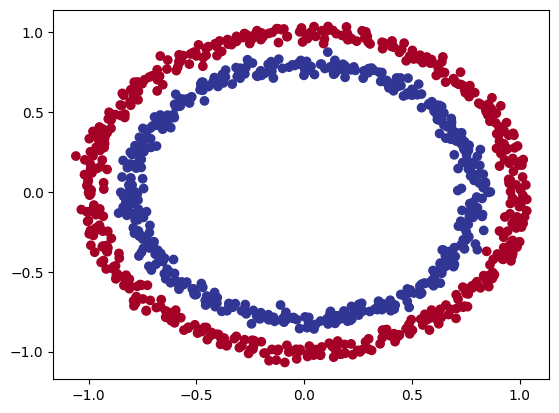

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y, cmap= plt.cm.RdYlBu)

In [4]:
print(f"First 5 samples of X:\n  {X[:5]}")
print(f"First 5 samples of y:\n  {y[:5]}")

First 5 samples of X:
  [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
  [1 1 1 1 0]


In [5]:
import pandas as pd
import numpy as np
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
circles.head(10)

C:\Users\Nihar\AppData\Local\Temp\ipykernel_8212\3038825017.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f"values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensor and create train and test splits

In [9]:
import torch 
torch.__version__

'2.2.0+cu118'

In [10]:
type(X)

numpy.ndarray

In [11]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [12]:
X.type

<function Tensor.type>

In [13]:
X.dtype

torch.float32

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [17]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscale to 5 features
        # self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and output to single feature

        self.two_linear_layer = nn.Sequential(
                                                nn.Linear(in_features=2, out_features=5),
                                                nn.Linear(in_features=5, out_features=1))
    def forward(self, x):
        return self.two_linear_layer(x) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (two_linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=8,2&seed=0.06315&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [19]:
# Lets replicate the model above using nn.sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1861, -0.3564],
                      [-0.5104,  0.4476],
                      [ 0.0164,  0.6071],
                      [-0.4404, -0.5096],
                      [ 0.4362,  0.2995]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0131,  0.2693,  0.0336,  0.1710, -0.1922], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4098,  0.0033, -0.0745, -0.3581, -0.2105]], device='cuda:0')),
             ('1.bias', tensor([0.0749], device='cuda:0'))])

In [22]:
# Make Prediction
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f" Length of prediction: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f" Length of prediction: {len(y_test)}, shape: {y_test.shape}")
print(f"\n First 10 predictions:\n {untrained_preds[:10]}")
print(f"\n First 10 labels:\n {y_test[:10]}")

 Length of prediction: 200, shape: torch.Size([200, 1])
 Length of prediction: 200, shape: torch.Size([200])

 First 10 predictions:
 tensor([[ 0.1570],
        [ 0.2728],
        [-0.1098],
        [ 0.2324],
        [-0.0510],
        [ 0.0193],
        [ 0.2990],
        [ 0.2398],
        [-0.1118],
        [ 0.2812]], device='cuda:0')

 First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup loss function and optimizer

In [23]:
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(), lr= 0.1)


In [24]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()

    acc = (correct/len(y_pred)) * 100
    return acc

In [25]:
a, b = X[:,0], X[:,0]

In [26]:
torch.eq(a,b).sum().item() # torch.eq(a,b) -> howmany item are equal in both a and b

1000

In [27]:
len(torch.eq(a,b))

1000

In [28]:
x = torch.tensor(10000)
x

tensor(10000)

In [29]:
x.item()

10000

# Train Model:

- Forward Pass
- Claculate the loss 
- Optimizer zero grad
- Loss backward (backpropagation)
- Optimizer step (Gradient Descent)



## 3.1 Going from raw logits -> prediction probabilities -> prediction label



In [30]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# View the first 5 outputs of the forawrad pass on the test data
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1570],
        [ 0.2728],
        [-0.1098],
        [ 0.2324],
        [-0.0510]], device='cuda:0')

In [32]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [33]:
y_pred = torch.sigmoid(y_logits)
y_pred

tensor([[0.5392],
        [0.5678],
        [0.4726],
        [0.5578],
        [0.4873]], device='cuda:0')

In [34]:
torch.round(y_pred)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

In [35]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [36]:
torch.eq(y_pred.squeeze(), y_pred_labels.squeeze())

tensor([False, False, False, False, False], device='cuda:0')

# Building a Training and testing Loop

In [37]:
device

'cuda'

In [38]:
#!nvidia-smi

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data into target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/ Accuarcy
    #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
    loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # turn logits -> pred probs -> pred labels
    
        # 2. Calculate test loss/ Accuarcy
        #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
        test_loss = loss_fn(test_logits,y_test) # nn.BCEWithLogitsLoss expects raw logits as input
    
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Accuarcy: {test_acc:.2f}%")

    

    
    

Epoch: 0 | Loss: 0.69545 | Accuracy: 52.00% | Test loss: 0.70345 | Test Accuarcy: 47.00%
Epoch: 10 | Loss: 0.69479 | Accuracy: 52.50% | Test loss: 0.70193 | Test Accuarcy: 46.00%
Epoch: 20 | Loss: 0.69433 | Accuracy: 52.25% | Test loss: 0.70073 | Test Accuarcy: 46.00%
Epoch: 30 | Loss: 0.69399 | Accuracy: 51.50% | Test loss: 0.69976 | Test Accuarcy: 46.00%
Epoch: 40 | Loss: 0.69375 | Accuracy: 51.75% | Test loss: 0.69898 | Test Accuarcy: 45.50%
Epoch: 50 | Loss: 0.69357 | Accuracy: 51.88% | Test loss: 0.69833 | Test Accuarcy: 46.00%
Epoch: 60 | Loss: 0.69343 | Accuracy: 51.50% | Test loss: 0.69779 | Test Accuarcy: 46.50%
Epoch: 70 | Loss: 0.69332 | Accuracy: 51.62% | Test loss: 0.69734 | Test Accuarcy: 46.00%
Epoch: 80 | Loss: 0.69325 | Accuracy: 51.62% | Test loss: 0.69696 | Test Accuarcy: 46.00%
Epoch: 90 | Loss: 0.69319 | Accuracy: 51.50% | Test loss: 0.69664 | Test Accuarcy: 46.00%


In [40]:
## 4. Make predictions and evaluate the model

# Model isn't learning anything

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [41]:
# import requests 
# from pathlib import Path

# if Path("helper_functions.py").is_file():
#     print("Skip Download")
# else:
#     print("Download !!!")
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py")
#     with open("helper_functions.py", "wb") as f:
#         f.write(request.content)

# from helper_functions import plot_predictions, plot_decision_boundary

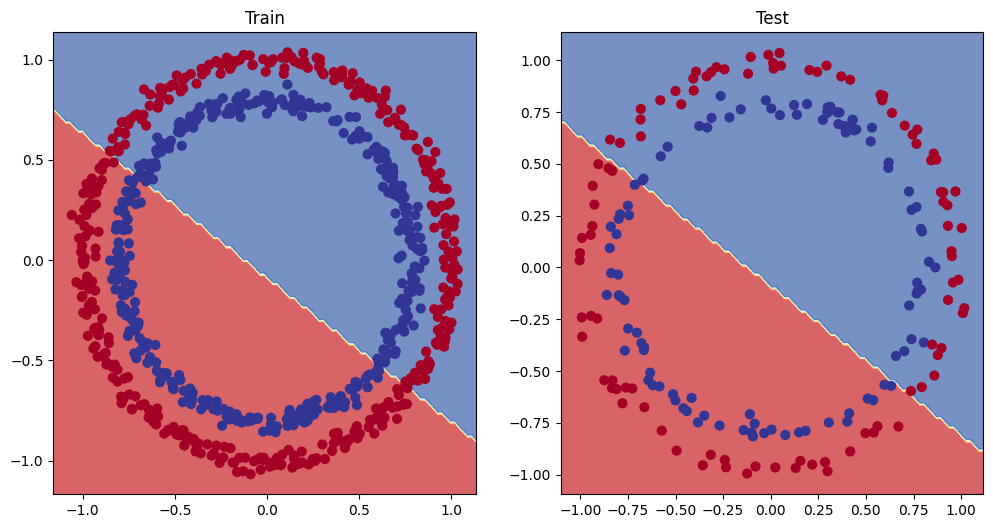

In [42]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [43]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1579, -0.3224],
                      [-0.5099,  0.4481],
                      [ 0.0240,  0.6160],
                      [-0.4168, -0.4810],
                      [ 0.4534,  0.3199]])),
             ('0.bias', tensor([ 0.0061,  0.2696,  0.0384,  0.1873, -0.1809])),
             ('1.weight',
              tensor([[-0.3675, -0.0118, -0.1311, -0.2924, -0.2607]])),
             ('1.bias', tensor([0.0259]))])

## 5. Improve a model  (From a model perspective)



In [44]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=1, bias=True)
)

In [45]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [46]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
        

In [47]:
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    params=model_1.parameters(), lr= 0.1)


In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put the data into target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/ Accuarcy
    #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
    loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # turn logits -> pred probs -> pred labels
    
        # 2. Calculate test loss/ Accuarcy
        #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
        test_loss = loss_fn(test_logits,y_test) # nn.BCEWithLogitsLoss expects raw logits as input
    
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Accuarcy: {test_acc:.2f}%")

    


Epoch: 0 | Loss: 0.69305 | Accuracy: 50.00% | Test loss: 0.69305 | Test Accuarcy: 50.00%
Epoch: 100 | Loss: 0.69210 | Accuracy: 70.62% | Test loss: 0.69230 | Test Accuarcy: 64.50%
Epoch: 200 | Loss: 0.69100 | Accuracy: 72.62% | Test loss: 0.69145 | Test Accuarcy: 69.00%
Epoch: 300 | Loss: 0.68870 | Accuracy: 76.50% | Test loss: 0.68967 | Test Accuarcy: 75.50%
Epoch: 400 | Loss: 0.68181 | Accuracy: 79.25% | Test loss: 0.68416 | Test Accuarcy: 77.50%
Epoch: 500 | Loss: 0.63996 | Accuracy: 93.25% | Test loss: 0.64815 | Test Accuarcy: 89.50%
Epoch: 600 | Loss: 0.51286 | Accuracy: 55.38% | Test loss: 0.52149 | Test Accuarcy: 61.50%
Epoch: 700 | Loss: 0.39763 | Accuracy: 72.00% | Test loss: 0.44523 | Test Accuarcy: 69.50%
Epoch: 800 | Loss: 0.01827 | Accuracy: 100.00% | Test loss: 0.03195 | Test Accuarcy: 100.00%
Epoch: 900 | Loss: 0.00568 | Accuracy: 100.00% | Test loss: 0.01327 | Test Accuarcy: 100.00%


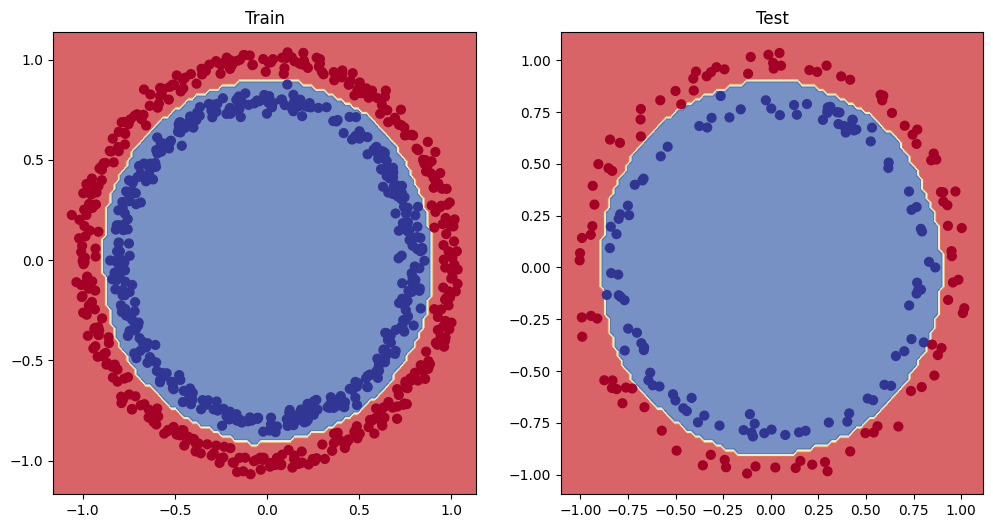

In [49]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [50]:
# Construct a model that subclasses nn.Module
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 2 features and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writting operations leverages speed up where possible behind the scenes


In [51]:
model_2 = CircleModelV2().to(device)

In [52]:
next(model_2.parameters()).device

device(type='cuda', index=0)

In [53]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr= 0.1)


In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data into target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_2.train()

    # 1. forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/ Accuarcy
    #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
    loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # turn logits -> pred probs -> pred labels
    
        # 2. Calculate test loss/ Accuarcy
        #loss = loss_fn(torch.sigmoid(y_logits),y_train) # nn.BCELoss expects raw logits as input
        test_loss = loss_fn(test_logits,y_test) # nn.BCEWithLogitsLoss expects raw logits as input
    
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Accuarcy: {test_acc:.2f}%")

    

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 10 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 20 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 30 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 40 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 50 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 60 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 70 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 80 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%
Epoch: 90 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test Accuarcy: 51.00%


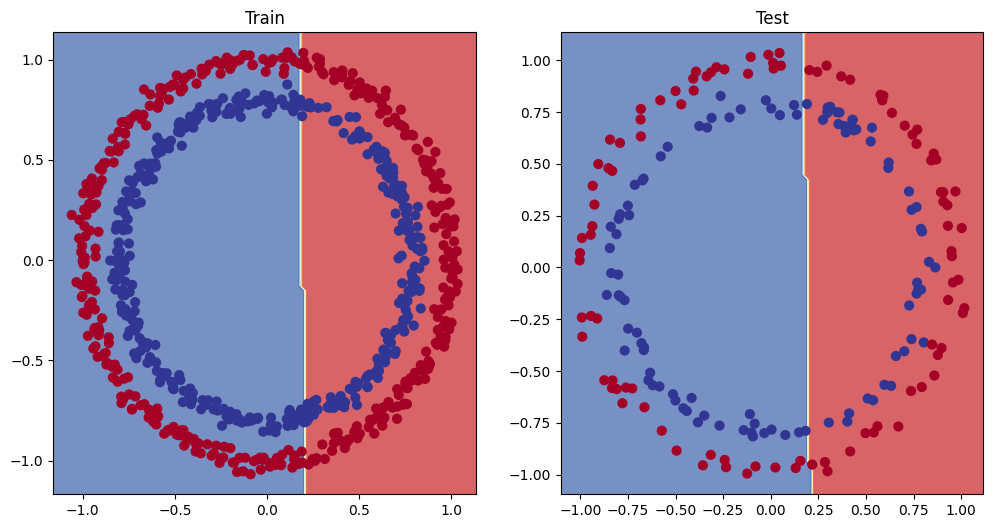

In [55]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# 5.1 Preparing data to see if our model can fit a straight line
## One way to troubleshoot to alarger problem is to test out smaller problem

In [56]:
# Create some data

weight = 0.7
bias = 0.3
start = 0
end= 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [57]:
train_split = int(0.8 * len(X_regression))

X_train_regression , y_train_regression = X_regression[:train_split], y_regression[:train_split]

X_test_regression , y_test_regression = X_regression[train_split:], y_regression[train_split:]
        

In [58]:
len(X_train_regression),len(X_test_regression)

(80, 20)

In [59]:
def plot_predictions(train_data= X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={'size':14})

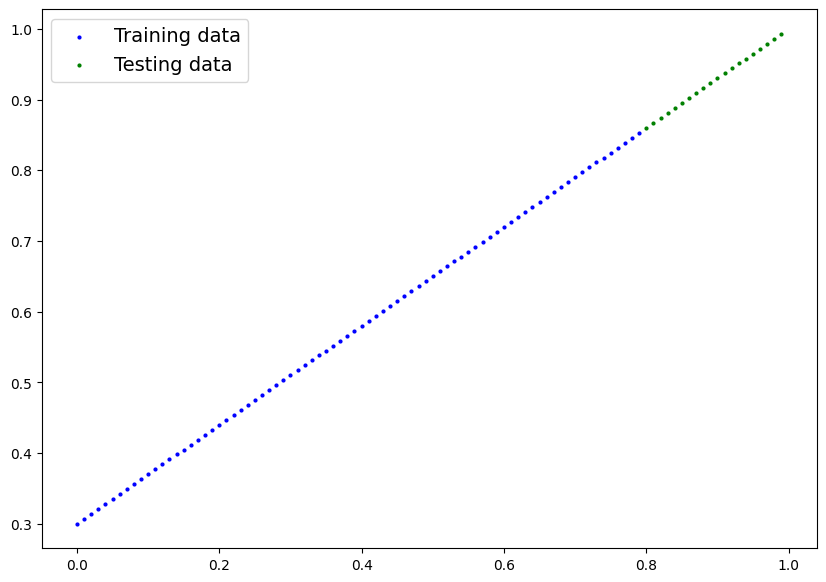

In [60]:
plot_predictions(train_data= X_train_regression,
                     train_labels = y_train_regression,
                     test_data = X_test_regression,
                     test_labels = y_test_regression,
                     predictions = None)

In [61]:
X_train_regression[:10], X_test_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.8000],
         [0.8100],
         [0.8200],
         [0.8300],
         [0.8400],
         [0.8500],
         [0.8600],
         [0.8700],
         [0.8800],
         [0.8900]]))

In [62]:
## 5.2 Adjust 'model_2' to fit a straight line

In [63]:
# Same architecture as model_1

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=1, out_features=10) # takes in 2 features and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [64]:
model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)).to(device)

In [65]:
model_3

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [66]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_3.parameters(), lr=0.1)

In [67]:
# Train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put the data into target device
X_train_regression, y_train_regression, X_test_regression, y_test_regression = X_train_regression.to(device), y_train_regression.to(device), X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_3.train()
    y_pred = model_3(X_train_regression)
    loss = loss_fn(y_pred,y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #testing
    model_3.eval()
    with torch.inference_mode():
        test_pred = model_3(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss : {test_loss:.5f}")
        
    

Epoch: 0 | Loss: 0.86866 | Test loss : 0.49113
Epoch: 100 | Loss: 0.07695 | Test loss : 0.32466
Epoch: 200 | Loss: 0.04995 | Test loss : 0.14866
Epoch: 300 | Loss: 0.07683 | Test loss : 0.17396
Epoch: 400 | Loss: 0.05364 | Test loss : 0.17281
Epoch: 500 | Loss: 0.05112 | Test loss : 0.14090
Epoch: 600 | Loss: 0.05578 | Test loss : 0.14577
Epoch: 700 | Loss: 0.06441 | Test loss : 0.14215
Epoch: 800 | Loss: 0.04880 | Test loss : 0.14198
Epoch: 900 | Loss: 0.06740 | Test loss : 0.13174


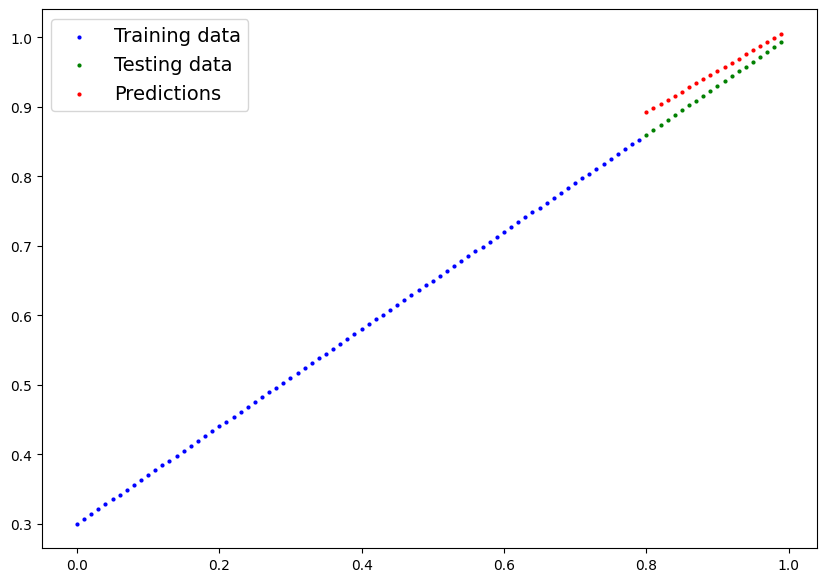

In [68]:
#Prediction
model_3.eval()
with torch.inference_mode():
    y_pred = model_3(X_test_regression)

# Plot data and predictions
plot_predictions(train_data= X_train_regression.cpu(),
                     train_labels = y_train_regression.cpu(),
                     test_data = X_test_regression.cpu(),
                     test_labels = y_test_regression.cpu(),
                     predictions = y_pred.cpu())

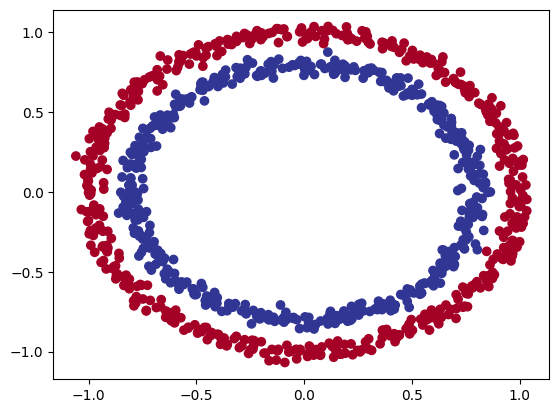

In [69]:
# 6. The missing piece: non-linearity
## 6.1 recreating non-linear data (red and blue circles)
plt.scatter(x=X[:,0],y=X[:,1],c=y, cmap= plt.cm.RdYlBu)

In [70]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')

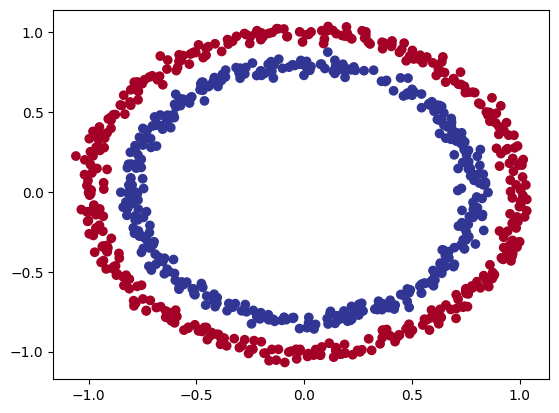

In [71]:
plt.scatter(x=X_train[:,0].cpu(),y=X_train[:,1].cpu(),c=y_train.cpu(), cmap= plt.cm.RdYlBu)

In [72]:
# Building a model with non-linear activation functions

class CircleModelV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 2 features and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # relu is a non linear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [73]:
model_4 = CircleModelV4().to(device)
model_4

CircleModelV4(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [74]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [75]:
# LOSS and OPTIMIZER

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr =0.1)

# Classification model:
- Email : Spam or Not Spam
- Credicard :Fraud or Not Fraud
- Insurance Claim: Fault or Not Fault

In [76]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]], device='cuda:0')

In [77]:
# Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_4.train()
    
    # 1 Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing 
    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred= test_pred)
    
    
    # print out what's happening
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Accuarcy: {test_acc:.2f}%")

        

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test loss: 0.69319 | Test Accuarcy: 50.00%
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88% | Test loss: 0.69102 | Test Accuarcy: 52.50%
Epoch: 200 | Loss: 0.68977 | Accuracy: 53.37% | Test loss: 0.68940 | Test Accuarcy: 55.00%
Epoch: 300 | Loss: 0.68795 | Accuracy: 53.00% | Test loss: 0.68723 | Test Accuarcy: 56.00%
Epoch: 400 | Loss: 0.68517 | Accuracy: 52.75% | Test loss: 0.68411 | Test Accuarcy: 56.50%
Epoch: 500 | Loss: 0.68102 | Accuracy: 52.75% | Test loss: 0.67941 | Test Accuarcy: 56.50%
Epoch: 600 | Loss: 0.67515 | Accuracy: 54.50% | Test loss: 0.67285 | Test Accuarcy: 56.00%
Epoch: 700 | Loss: 0.66659 | Accuracy: 58.38% | Test loss: 0.66322 | Test Accuarcy: 59.00%
Epoch: 800 | Loss: 0.65160 | Accuracy: 64.00% | Test loss: 0.64757 | Test Accuarcy: 67.50%
Epoch: 900 | Loss: 0.62362 | Accuracy: 74.00% | Test loss: 0.62145 | Test Accuarcy: 79.00%


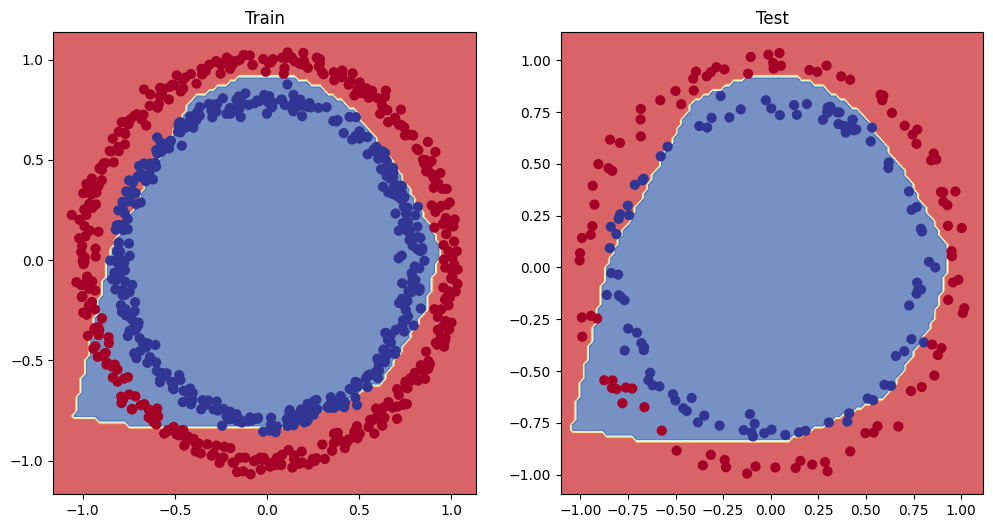

In [78]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

# 7. Replicating non-linear activation functions

Neural Networks, rather than us telling the model what to learn, we give it the tools to discover patterns in the data and it tries to figure out the patterns on its own

In [79]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

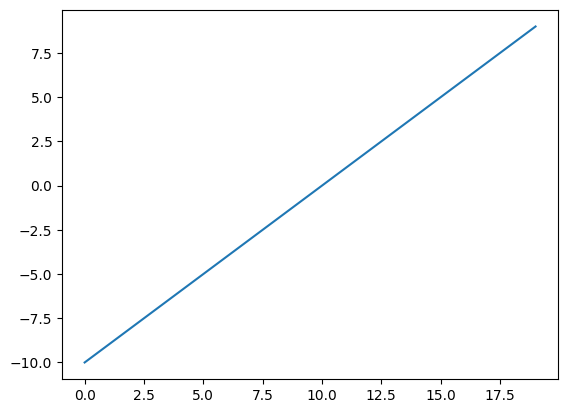

In [80]:
# Visualize the tensor
plt.plot(A);

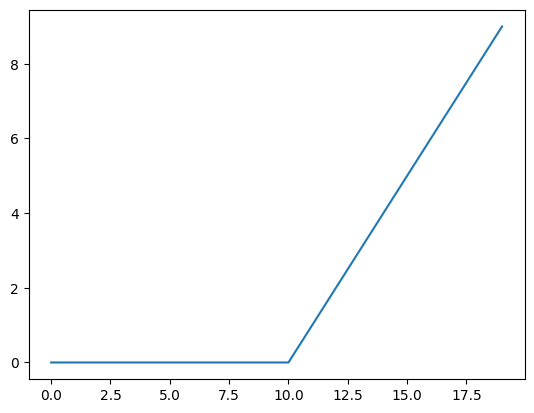

In [81]:
plt.plot(torch.relu(A))

In [82]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

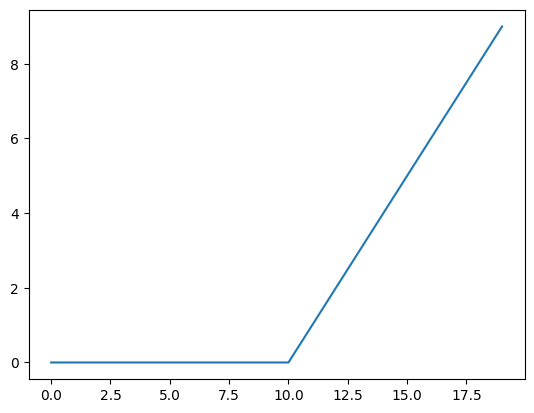

In [83]:
plt.plot(relu(A))

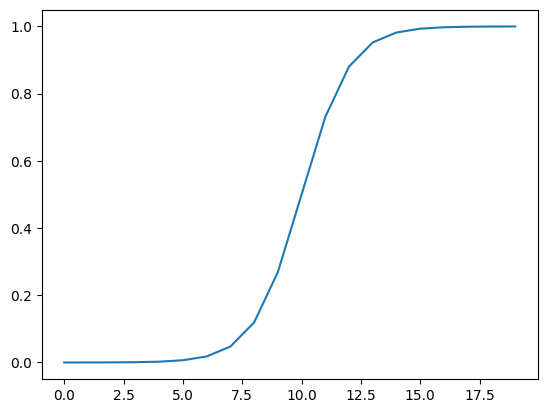

In [85]:
def sigmoid(x):
    return (1 / ( 1 + torch.exp(-x)))

plt.plot(sigmoid(A))

In [ ]:
## 8. 